In [1]:
from cutqc.main import CutQC
from qiskit import *
import numpy as np

In [2]:
nq = 6
full_circ = QuantumCircuit(nq)
for i in range(nq-1):
    full_circ.cx(i, i+1)
full_circ.rx(np.pi, nq-1)
for i in range(nq-1,0,-1):
    full_circ.cx(i-1, i)
print(full_circ)

                                                                
q_0: ──■─────────────────────────────────────────────────────■──
     ┌─┴─┐                                                 ┌─┴─┐
q_1: ┤ X ├──■───────────────────────────────────────────■──┤ X ├
     └───┘┌─┴─┐                                       ┌─┴─┐└───┘
q_2: ─────┤ X ├──■─────────────────────────────────■──┤ X ├─────
          └───┘┌─┴─┐                             ┌─┴─┐└───┘     
q_3: ──────────┤ X ├──■───────────────────────■──┤ X ├──────────
               └───┘┌─┴─┐                   ┌─┴─┐└───┘          
q_4: ───────────────┤ X ├──■─────────────■──┤ X ├───────────────
                    └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘               
q_5: ────────────────────┤ X ├┤ RX(π) ├┤ X ├────────────────────
                         └───┘└───────┘└───┘                    


In [3]:
max_subcircuit_qubit = 4
num_subcircuits = [2]
max_cuts = 2
verbose = 2

circuits = {'my_circ':full_circ}

cutqc = CutQC(circuits, max_subcircuit_qubit, num_subcircuits, max_cuts, verbose)

## Prior functionality:
The code below will no longer execute because I've changed the CutQC `__init__` function so it does *not* immediately call `_cut()`

However, the output shows how the circuit above should be partitioned

In [10]:
cutsoln = cutqc.cut_solns[0]
print(cutsoln.keys())
for i, subcirc in enumerate(cutsoln['subcircuits']):
    print('Subcircuit', i)
    print(subcirc)

dict_keys(['circuit', 'max_subcircuit_qubit', 'subcircuits', 'complete_path_map', 'searcher_time', 'num_rho_qubits', 'num_O_qubits', 'num_d_qubits', 'objective', 'positions', 'counter', 'cost_estimate'])
Subcircuit 0
                         
q_0: ──■──────────────■──
     ┌─┴─┐          ┌─┴─┐
q_1: ┤ X ├──■────■──┤ X ├
     └───┘┌─┴─┐  │  └───┘
q_2: ─────┤ X ├──┼───────
          └───┘┌─┴─┐     
q_3: ──────────┤ X ├─────
               └───┘     
Subcircuit 1
                                            
q_0: ──■─────────────────────────────────■──
     ┌─┴─┐                             ┌─┴─┐
q_1: ┤ X ├──■───────────────────────■──┤ X ├
     └───┘┌─┴─┐                   ┌─┴─┐└───┘
q_2: ─────┤ X ├──■─────────────■──┤ X ├─────
          └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘     
q_3: ──────────┤ X ├┤ RX(π) ├┤ X ├──────────
               └───┘└───────┘└───┘          


## New functionality:
Now, instead of calling `_cut()` which would *find* and *cut* the circuit we first solve the MIP model for the initial circuit.
Solving this model will use the Gurobi optimizer to find the best cut locations given our constrains. We'll then use this same model
to repeatedly cut circuits which have identical structure up to the values of their parametrized rotation gates.

In [4]:
mip_model = cutqc.get_MIP_model(max_subcircuit_qubit, num_subcircuits, max_cuts)
mip_model.subcircuits_vertices

Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only


[['q[0]0 q[1]0', 'q[1]1 q[2]0', 'q[1]2 q[2]3', 'q[0]1 q[1]3'],
 ['q[2]1 q[3]0',
  'q[3]1 q[4]0',
  'q[4]1 q[5]0',
  'q[4]2 q[5]1',
  'q[3]2 q[4]3',
  'q[2]2 q[3]3']]

In [6]:
subcircs, cpm = cutqc.get_subcircs_from_model(full_circ, mip_model)
for i, subcirc in enumerate(subcircs):
    print('Subcirc', i)
    print(subcirc)

Subcirc 0
                         
q_0: ──■──────────────■──
     ┌─┴─┐          ┌─┴─┐
q_1: ┤ X ├──■────■──┤ X ├
     └───┘┌─┴─┐  │  └───┘
q_2: ─────┤ X ├──┼───────
          └───┘┌─┴─┐     
q_3: ──────────┤ X ├─────
               └───┘     
Subcirc 1
                                            
q_0: ──■─────────────────────────────────■──
     ┌─┴─┐                             ┌─┴─┐
q_1: ┤ X ├──■───────────────────────■──┤ X ├
     └───┘┌─┴─┐                   ┌─┴─┐└───┘
q_2: ─────┤ X ├──■─────────────■──┤ X ├─────
          └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘     
q_3: ──────────┤ X ├┤ RX(π) ├┤ X ├──────────
               └───┘└───────┘└───┘          


In [7]:
nq = 6
full_circ2 = QuantumCircuit(nq)
for i in range(nq-1):
    full_circ2.cx(i, i+1)
full_circ2.rx(2*np.pi, nq-1)
for i in range(nq-1,0,-1):
    full_circ2.cx(i-1, i)
print(full_circ2)

                                                                 
q_0: ──■──────────────────────────────────────────────────────■──
     ┌─┴─┐                                                  ┌─┴─┐
q_1: ┤ X ├──■────────────────────────────────────────────■──┤ X ├
     └───┘┌─┴─┐                                        ┌─┴─┐└───┘
q_2: ─────┤ X ├──■──────────────────────────────────■──┤ X ├─────
          └───┘┌─┴─┐                              ┌─┴─┐└───┘     
q_3: ──────────┤ X ├──■────────────────────────■──┤ X ├──────────
               └───┘┌─┴─┐                    ┌─┴─┐└───┘          
q_4: ───────────────┤ X ├──■──────────────■──┤ X ├───────────────
                    └───┘┌─┴─┐┌────────┐┌─┴─┐└───┘               
q_5: ────────────────────┤ X ├┤ RX(2π) ├┤ X ├────────────────────
                         └───┘└────────┘└───┘                    


In [8]:
subcircs, cpm = cutqc.get_subcircs_from_model(full_circ2, mip_model)
for i, subcirc in enumerate(subcircs):
    print('Subcirc', i)
    print(subcirc)

Subcirc 0
                         
q_0: ──■──────────────■──
     ┌─┴─┐          ┌─┴─┐
q_1: ┤ X ├──■────■──┤ X ├
     └───┘┌─┴─┐  │  └───┘
q_2: ─────┤ X ├──┼───────
          └───┘┌─┴─┐     
q_3: ──────────┤ X ├─────
               └───┘     
Subcirc 1
                                             
q_0: ──■──────────────────────────────────■──
     ┌─┴─┐                              ┌─┴─┐
q_1: ┤ X ├──■────────────────────────■──┤ X ├
     └───┘┌─┴─┐                    ┌─┴─┐└───┘
q_2: ─────┤ X ├──■──────────────■──┤ X ├─────
          └───┘┌─┴─┐┌────────┐┌─┴─┐└───┘     
q_3: ──────────┤ X ├┤ RX(2π) ├┤ X ├──────────
               └───┘└────────┘└───┘          


## Test this with DQVA circuits

In [10]:
from cutDQVA import gen_dqva
import networkx as nx

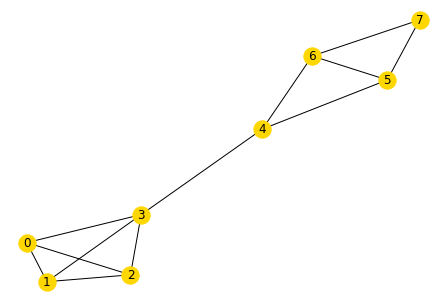

In [11]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)])
nx.draw_spring(G, with_labels=True, node_color='gold')

In [ ]:
nq = len(G.nodes)
kl_bisection = ({0,1,2,3}, {4,5,6,7})
dqva_circ = gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state,
                     cut=True, mixer_order=cur_permutation, verbose=0,
                     decompose_toffoli=2, barriers=0, hot_nodes=[hotnode])